In [1]:
import pandas as pd # Library for data frames in python
import numpy as np # Scientific computing library with lots of valuable methods
from sklearn.cross_decomposition import PLSRegression # Partial least squares library
# Allow for inline scripts in the notebook.
%matplotlib inline 
import matplotlib.pyplot as plt # Library for easy plotting
from sklearn.preprocessing import StandardScaler # Scaler library to normalise datasets
from sklearn.model_selection import train_test_split # Library for splitting data into test and training sets
from sklearn.decomposition import PCA # Scikit learn library for Principal Component Analysis
from sklearn.model_selection import StratifiedKFold # library for creating k partitions 
import seaborn as sns # library for heatmap plots
from sklearn.model_selection import cross_val_score # Library to evaluate models with a cross validation 
from sklearn.linear_model import ElasticNet # Elastic net package
from sklearn.linear_model import Ridge # Ridge regression analysis package
from sklearn.linear_model import Lasso # Lasso regression analysis package

In [2]:
print ("Pandas version ",pd.__version__)
print ("Numpy version ",np.__version__)
print ("Seaborn version ",sns.__version__)

Pandas version  0.23.4
Numpy version  1.13.3
Seaborn version  0.9.0


# Data Preparation

In [3]:
# Descriptors matrix is developed by Egon Willighagen from Maastricht University. 
# It is computed from the values 
descriptors = pd.read_csv("descriptors.csv");
print('Dimensions of data frame is', descriptors.shape);

Dimensions of data frame is (1050, 247)


In [4]:
nNullVals = descriptors.isnull().sum().sum()
print('There are', nNullVals, 'null values in the dataframe')
# Remove columns where all values are na.
descriptors = descriptors.dropna(axis='columns', how='all');
print('Dimensions of data frame are', descriptors.shape);

There are 31503 null values in the dataframe
Dimensions of data frame are (1050, 217)


In [5]:
# There still might be some NaNs in each of the rows.
nans = np.isnan(descriptors).sum().sum()
print('There are', nans, 'nans in the dataframe')

There are 3 nans in the dataframe


In [6]:
# Method for imputing nans with mean of the column, 
# so we don't have to remove the whole row if a couple of values are missing

# The function will return a pandas dataframe without NaNs.
# Input matrix X is the descriptors matrix. 
def imputeNansWithMean (X):
    # split input into header values and datapoints.
    header = list(X)
    X = X.values
    
    # If the input matrix does not contain NaNs, exit methods. 
    if (np.isnan(X).sum()==0):
        print("No nans")
        return X
    # Array of NaN indices
    nans= np.argwhere(np.isnan(X))
    # Loop through NaNs and impute indices with means of the whole column
    for i in range(np.size(nans,0)):
        X[nans[i][0],nans[i][1]] = np.nanmean(X[:,nans[i][1]])
    return pd.DataFrame(data = X, columns = header)
        

In [7]:
# Method call for removing NaNs
descriptors = imputeNansWithMean(descriptors)

In [8]:
# Check number of NaNs
nans = np.isnan(descriptors).sum().sum()
print('There are', nans, 'nans in the dataframe')

There are 0 nans in the dataframe


In [9]:
descriptors= descriptors.drop(['Unnamed: 0'], axis =1)
descriptors.head()

,molSIDs,XLogP,MW,LipinskiFailures,nRotB,MLogP,nAtomLAC,nAtomP,nAtomLC,nB,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
0,124897530.0,1.135,369.168856,0.0,10.0,2.89,3.0,8.0,10.0,28.0,...,38.705835,0.587339,-0.212712,-0.098779,0.094417,-0.105979,4.0,6.0,28.677761,57.044239
1,124897303.0,4.498,249.095378,0.0,2.0,3.11,2.0,18.0,2.0,21.0,...,21.080331,0.140528,-0.058828,-0.015299,0.003398,0.002364,0.0,1.0,15.641484,39.578516
2,124753561.0,4.554,657.230885,0.0,11.0,4.21,0.0,9.0,4.0,52.0,...,103.548597,0.986870,-0.554960,0.077083,0.204425,-0.347424,0.0,8.0,57.764452,98.933548
3,124753354.0,8.321,501.146461,1.0,9.0,2.89,4.0,16.0,5.0,34.0,...,44.567510,0.770304,-0.337273,-0.243732,0.222481,-0.064752,2.0,4.0,40.743589,70.138411
4,121286038.0,4.515,637.224657,0.0,10.0,4.32,2.0,24.0,4.0,52.0,...,90.067994,0.906852,-0.523297,0.081751,0.016048,0.040308,2.0,6.0,53.306245,97.709755


In [10]:
scoreData = pd.read_csv("data.csv");
sid_activityScore = scoreData.loc[5:,['PUBCHEM_SID','PUBCHEM_ACTIVITY_SCORE']];

/Users/daraakdag/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,8,9,10,11,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Because some columns have mixed values, the pandas dataframe will parse values as floating points.
sid_activityScore.head()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_SCORE
5,842121.0,0.0
6,842122.0,0.0
7,842123.0,0.0
8,842124.0,0.0
9,842125.0,0.0


In [12]:
# Convert floating point values to integers. 
sid_activityScore['PUBCHEM_SID'] = sid_activityScore['PUBCHEM_SID'].astype(np.int64)
sid_activityScore['PUBCHEM_ACTIVITY_SCORE'] = sid_activityScore['PUBCHEM_ACTIVITY_SCORE'].astype(np.int64)

In [13]:
sid_activityScore.head()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_SCORE
5,842121,0
6,842122,0
7,842123,0
8,842124,0
9,842125,0


In [14]:
# Insert activity score column with values 0
descriptors.insert(0,'ActivityScore',int(0))

In [15]:
descriptors.tail()

,ActivityScore,molSIDs,XLogP,MW,LipinskiFailures,nRotB,MLogP,nAtomLAC,nAtomP,nAtomLC,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
1045,0,843609.0,3.454,321.114713,0.0,8.0,2.34,2.0,12.0,6.0,...,35.829365,0.560950,-0.360243,0.116596,0.019901,-0.292837,0.0,4.0,31.140933,47.675067
1046,0,843396.0,2.894,334.121195,0.0,3.0,2.01,0.0,11.0,3.0,...,52.683298,0.668867,-0.550880,0.466517,-0.486335,0.420218,0.0,6.0,34.433726,47.746274
1047,0,843202.0,1.316,423.179421,0.0,6.0,3.11,2.0,13.0,3.0,...,53.978743,0.889698,-0.472932,-0.151360,0.434316,-0.400282,1.0,7.0,38.656175,64.459825
1048,0,842577.0,2.752,271.024932,0.0,4.0,1.79,0.0,7.0,2.0,...,25.532622,0.344138,-0.179113,-0.030790,0.078024,-0.033099,1.0,3.0,19.271070,34.726930
1049,0,842218.0,3.820,368.140389,0.0,4.0,3.00,2.0,9.0,3.0,...,39.468120,0.326019,-0.097623,-0.115749,0.072170,0.032923,0.0,4.0,28.295347,56.584653


In [16]:
# Lookup activity scores for each molSID of descriptors matrix in the sid_activityScore dataframe 
# and insert activity score into descriptor matrix. 
for idx,val in enumerate(descriptors['molSIDs']):
    temp = sid_activityScore.loc[sid_activityScore['PUBCHEM_SID']==val];
    score = temp.iloc[0][1]
    descriptors.at[idx,'ActivityScore'] = score;


In [17]:
descriptors.head()

,ActivityScore,molSIDs,XLogP,MW,LipinskiFailures,nRotB,MLogP,nAtomLAC,nAtomP,nAtomLC,...,ATSm5,ATSc1,ATSc2,ATSc3,ATSc4,ATSc5,nHBDon,nHBAcc,bpol,apol
0,0,124897530.0,1.135,369.168856,0.0,10.0,2.89,3.0,8.0,10.0,...,38.705835,0.587339,-0.212712,-0.098779,0.094417,-0.105979,4.0,6.0,28.677761,57.044239
1,0,124897303.0,4.498,249.095378,0.0,2.0,3.11,2.0,18.0,2.0,...,21.080331,0.140528,-0.058828,-0.015299,0.003398,0.002364,0.0,1.0,15.641484,39.578516
2,0,124753561.0,4.554,657.230885,0.0,11.0,4.21,0.0,9.0,4.0,...,103.548597,0.986870,-0.554960,0.077083,0.204425,-0.347424,0.0,8.0,57.764452,98.933548
3,10,124753354.0,8.321,501.146461,1.0,9.0,2.89,4.0,16.0,5.0,...,44.567510,0.770304,-0.337273,-0.243732,0.222481,-0.064752,2.0,4.0,40.743589,70.138411
4,0,121286038.0,4.515,637.224657,0.0,10.0,4.32,2.0,24.0,4.0,...,90.067994,0.906852,-0.523297,0.081751,0.016048,0.040308,2.0,6.0,53.306245,97.709755


# Create training and test distributions

In [18]:
# Initialise Data and Label variables X and Y from dataframe.
# X matrix is cut from 2nd index to exclude molecule SIDs. 
# Y is just the activity scores of the descriptors matrix.
X, Y = descriptors.iloc[:,2:].values, descriptors.iloc[:,0].values

In [19]:
print("X contains all variables with shape ",X.shape)
print("Y contains all labels with shape ",Y.shape)

X contains all variables with shape  (1050, 215)
Y contains all labels with shape  (1050,)


In [20]:
# Create test and training sets with 20:80 distribution
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2423)
print('Training data dimensions',X_train.shape, 'and trainng labels dimensions', Y_train.shape)
print('Test data dimensions', X_test.shape,'and trainng labels dimensions', Y_test.shape)

Training data dimensions (840, 215) and trainng labels dimensions (840,)
Test data dimensions (210, 215) and trainng labels dimensions (210,)


In [21]:
# Create standard scaler and use it to standardize training and test data
# Standardize features by removing the mean and scaling to unit variance
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

# Data Exploration

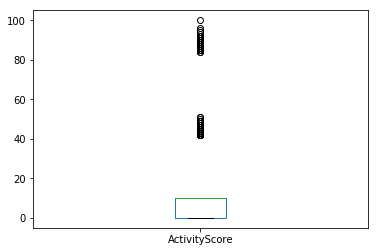

In [22]:
descriptors.ActivityScore.plot.box()

The above boxplot shows most our values are around zero with few outliers around 50 and 100 in activity score.

In [23]:
#PCA
scaled_X= StandardScaler().fit_transform(X)
# create PCA 
pca = PCA(n_components = 2)
# Transform scaled data to compute principal components of X
principalComponents = pca.fit_transform(scaled_X)
# Convert principal components to pandas data frame
principalDf = pd.DataFrame(data = principalComponents, columns=['Principal Component 1','principal Component2'])
print(principalDf.head())

   Principal Component 1  principal Component2
0               1.357482              2.927629
1              -6.862435             -4.695293
2              38.739496             -1.475900
3              11.250316              1.681124
4              35.441795             -4.963040


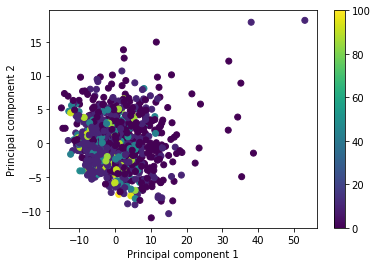

In [24]:
# Make scatterplot of principal components 
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=list(descriptors.ActivityScore)) 
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.colorbar()

The colorbar shows activity scores from 0-100

In [25]:
print("The first component of the PCA explains ", pca.explained_variance_ratio_[0], "% of the variance")
print("The second component of the PCA explains ", pca.explained_variance_ratio_[1], "% of the variance")

The first component of the PCA explains  0.296613312086 % of the variance
The second component of the PCA explains  0.0786670169465 % of the variance


# Investigate multicolinearity

In [26]:
# Calculate correlations between descriptors
descrptCorr = np.array(descriptors.corr())
# Fill the diagonal with zeros to easier view the multicolinearitie across descriptors
np.fill_diagonal(descrptCorr,0)
# Mask of values of correlation above 0.99
maskCorrAbove1 = np.where(descrptCorr>0.99)
# Use mask to select descriptors where correlation is above 0.99
descriptorsCorrAbove1 = list(set(np.array(list(descriptors))[maskCorrAbove1[0]]))

/Users/daraakdag/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


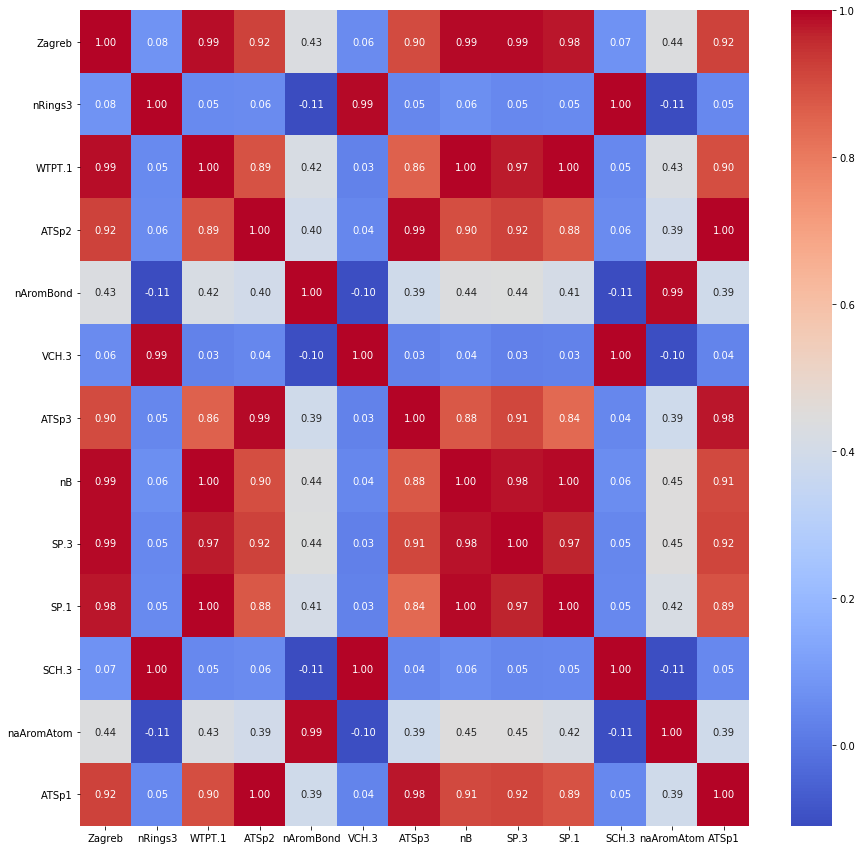

In [27]:
# Make plot large.
plt.rcParams["figure.figsize"] = (15,15)
# plot heatmap of 
heatmapDescriptors = sns.heatmap(descriptors[descriptorsCorrAbove1].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

The heatmap shows descriptors that have a colinearity of 1. These could be removed to see how it influences predicion accuracies. 

# Data analysis

In [28]:
# Create PLS model
pls1 = PLSRegression(n_components=3)
# Fit the model to training data
pls1.fit(X_train, Y_train)

PLSRegression(copy=True, max_iter=500, n_components=3, scale=True, tol=1e-06)

In [29]:
# Run model with crossvalidation on the test set with cross validation partitions 3
scores = cross_val_score(pls1,X_test,Y_test, cv = 3)

In [30]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.16 (+/- 0.13)


In [31]:
scores

array([-0.13483089, -0.10362893, -0.25230736])

In [32]:
# Create Elastic Net model
ENreg = ElasticNet(alpha=1, l1_ratio=0.5, normalize=False)
# Fit model to training data
ENreg.fit(X_train,Y_train)

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [33]:
# Estimate score on test data
print("Accuracy score of model on test data yields ", ENreg.score(X_test,Y_test))


Accuracy score of model on test data yields  0.055392111542


In [34]:
# Create ridge regression model with alpha 0.5
ridgeReg = Ridge(alpha=0.5)
# Fit model to training data
ridgeReg.fit(X_train, Y_train) 


Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [35]:
# Estimate score on test data
print("Accuracy score of model on test data yields ", ridgeReg.score(X_test,Y_test))

Accuracy score of model on test data yields  -0.0694226381602


In [36]:
# Create lasso regression model
lassoReg = Lasso(alpha=0.3, normalize=True)
# Fit model to training data
lassoReg.fit(X_train,Y_train)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [37]:
# estimate score on test data
print("Accuracy score of model on test data yields ", lassoReg.score(X_test,Y_test))

Accuracy score of model on test data yields  -0.0251369497031


# Conclusion
As we can see all our models do not give any indication of a correlation pattern across the different descriptors. It would be interesting to investigate more feature selection algorithms and perhaps remove entries which have 0 in activity score, and see how this would affect the prediction models. 